Spin Piolarized and Time-Resolved EPR Spectroscopy in MarS.


This notebook demonstrates how to use the MarS library to compute spin polarized and time-resolved EPR spectra

We'll explore:

1) Context logic for describing spin relaxation mechanisms
2) Population-based relaxation dynamics
3) Rotating Wave Approximation and Lindblad formalism
4) Full propagator computation beyond approximations


\
\
\
\
\
\
For any questions, please contact Arkady Samsonenko via: \
Telegram: @Arkady_Samsonenko \
Email: a.samsonenko.tomo.nsc.ru

In [1]:
# Import necessary libraries
import sys
import os
import math
from importlib import reload

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import optuna
import nevergrad as ng

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

# Import Mars library components
import mars
from mars import spin_system, spectra_manager, mesher, constants
from mars import utils
from mars import population

Some stuff might fail: issue in joblib


In [2]:
dtype = torch.float64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 1. Context Logic and Spin-Polarized Systems

In time-resolved EPR, we need to model how spin systems evolve after initial excitation. The Context class in MarS provides a comprehensive framework for defining these relaxation mechanisms.


A Context encapsulates the physical model of relaxation and initial state in time-resolved EPR. It specifies:

1) The basis where relaxation parameters and initial populations are defined
2) Initial populations or density matrix
3) Probabilities of transitions and superoperators

#### 1.1. Context Definition and Time Resolved Spectra

Here we introduce new object in MarS library - context. Context allows to describe relaxation mechanisms and initial populations

In [20]:
# Let's start from the sample creation

g_tensor = spin_system.Interaction(2.002, dtype=dtype, device=device)
zfs_interaction = spin_system.DEInteraction([500e6, 100e6], dtype=dtype, device=device)  # 500 and 100 MHz

base_spin_system = spin_system.SpinSystem(
    electrons=[1.0],  # S=1 triplet
    g_tensors=[g_tensor],
    electron_electron=[(0, 0, zfs_interaction)]
)

sample = spin_system.MultiOrientedSample(
    spin_system=base_spin_system,
    ham_strain=5e7,
    gauss=0.001,
    lorentz=0.001,
    device=device,
    dtype=dtype
)

Let's create Context object. It takes:

1) Initial populations if the populations are not under temperature equilibrium

2) Basis where the parameters are defined.

**Available Basis Options:**

1. **"eigen"** (default): Hamiltonian eigenbasis at resonance field

2. **"zfs"**: Zero-field splitting eigenbasis

3. **"multiplet"**: Total spin basis |S, M⟩

4. **"product"**: Individual spin projections |ms₁, ms₂, ...⟩

5. **Custom tensor**: Explicit transformation matrix with shape [...R, 1 ,N, N], where N is spin dimension, R is numer of orientations

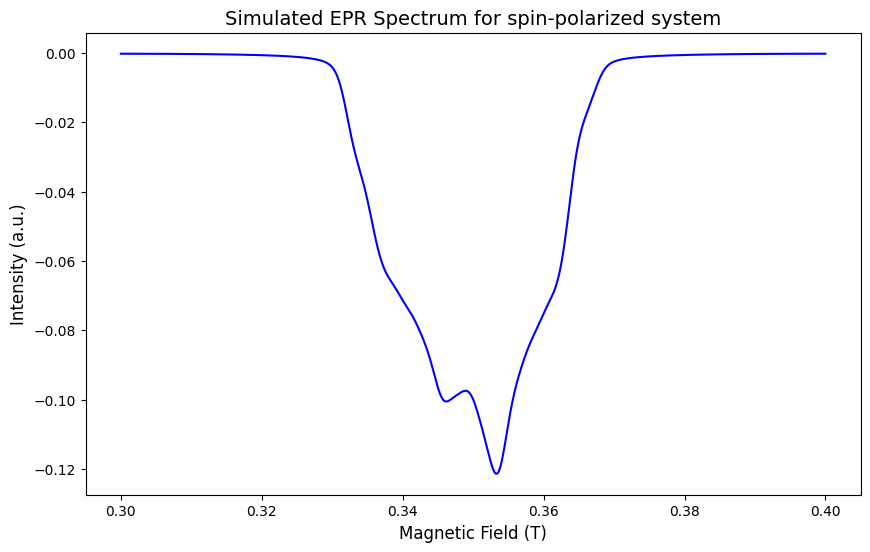

In [21]:
# Let's create some spectra with polarization
initial_populations = [0.2, 0.3, 0.5] 
context = population.Context(sample=sample, basis=None, init_populations=initial_populations, device=device, dtype=dtype) 
# Here we define Context with populations given in the Hamiltonian eigen basis in magnetic field


# StationarySpectra can take context to compute spin-polarized spectra
spectra_creator = spectra_manager.StationarySpectra(
    freq=9.8e9,    # Frequency in Hz
    sample=sample,
    harmonic=0, # absorbtion
    context=context, 
    device=device,
    dtype=dtype
)

# Define magnetic field range for simulation
fields = torch.linspace(0.30, 0.40, 1000, dtype=dtype, device=device)  # Field in Tesla

# Calculate spectrum
spectrum = spectra_creator(sample, fields)

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(fields.numpy(), spectrum.numpy(), 'b-')
plt.xlabel('Magnetic Field (T)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Simulated EPR Spectrum for spin-polarized system', fontsize=14)
plt.show()

As a result we observe spin-polarized system.

#### 1.2. Plot spin-polarized spectra for all possible predifined basis

Now, Let's plot spectra with populations given at all possible predefined basis

In [116]:
# Create function that makes it
def get_spectrum_with_context(context):
    spectra_creator = spectra_manager.StationarySpectra(
    freq=9.8e9,    # Frequency in Hz
    sample=sample,
    harmonic=0, # absorbtion
    context=context, 
    temperature=300.0,
    device=device,
    dtype=dtype
)

    # Define magnetic field range for simulation
    fields = torch.linspace(0.30, 0.40, 1000, dtype=dtype, device=device)  # Field in Tesla
    # Calculate spectrum
    spectrum = spectra_creator(sample, fields)
    
    return fields.cpu().numpy(), spectrum.cpu().numpy() / max(abs(spectrum.cpu().numpy()))

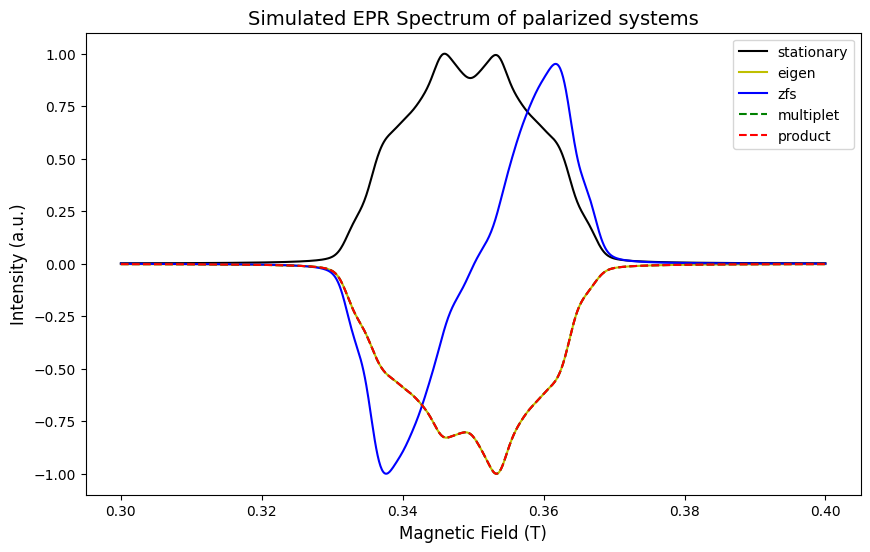

In [117]:
fields, spectrum_stationary = get_spectrum_with_context(None)  # stationary spectra

initial_populations = [0.2, 0.3, 0.5] 
context = population.Context(sample=sample, basis="zfs", init_populations=initial_populations, device=device, dtype=dtype) 
fields, spectrum_zfs = get_spectrum_with_context(context)  # zfs spectra

context = population.Context(sample=sample, basis="eigen", init_populations=initial_populations, device=device, dtype=dtype) 
fields, spectrum_eigen = get_spectrum_with_context(context)  # eigen basis spectra

context = population.Context(sample=sample, basis="multiplet", init_populations=initial_populations, device=device, dtype=dtype) 
fields, spectrum_mul = get_spectrum_with_context(context)  # multiplet spectra


initial_populations_product = [0.5, 0.3, 0.2]  # For the product basis we inverted the populations bacause product basis defined from the higher spin projection
context = population.Context(sample=sample, basis="product", init_populations=initial_populations_product, device=device, dtype=dtype) 
fields, spectrum_product = get_spectrum_with_context(context)  # product spectra



plt.figure(figsize=(10, 6))
plt.plot(fields, spectrum_stationary, 'black', label="stationary")
plt.plot(fields, spectrum_eigen, 'y-', label="eigen")
plt.plot(fields, spectrum_zfs, 'b-', label="zfs")
plt.plot(fields, spectrum_mul, 'g--', label="multiplet")
plt.plot(fields, spectrum_product, 'r--', label="product")

plt.xlabel('Magnetic Field (T)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Simulated EPR Spectrum of palarized systems', fontsize=14)
plt.legend()
plt.show()


We get expected result: \
In a magnetic field, the eigenbasis is practically equal to the multiplet basis, which is equal to the product basis.

# 2. Introduction to Time-Resolved Spectroscopy

In MarS, time-resolved EPR spectra are computed using three distinct methods, each with specific capabilities and limitations.

1) **Population (kinetic) dynamics**  
   This method solves a kinetic rate equation for the populations of spin energy levels:  

   $$
   \frac{d\mathbf{n}}{dt} = K \cdot \mathbf{n}(t),
   $$  

   where $\mathbf{n}$ is the vector of level populations and $K$ is the kinetic matrix.  
   It supports arbitrary spin Hamiltonians but cannot describe quantum coherences, coherent polarization transfer, or any effect that depends on off-diagonal elements of the density matrix.

2) **Density-based dynamics via rotating-wave approximation**  
   MarS provides two approaches to solve the full density matrix relaxation. Both solve the Liouville–von Neumann equation in Liouville space:  

   $$
   \frac{d\rho}{dt} = -i[H, \rho] + \mathcal{R}[\rho],
   $$  

   where $H$ is the Hamiltonian and $\mathcal{R}$ is the relaxation superoperator.  
   The first approach uses the rotating-wave approximation (RWA), which transforms the problem into a rotating frame. While computationally efficient, it imposes several key restrictions:
   - The g-tensor must be isotropic, so the Zeeman term takes the form  
     $G_x = g \mu_B S_x$, $G_y = g \mu_B S_y$, $G_z = g \mu_B S_z$., where Gx,  Gy, Gz are Zeeman Operators, $\mu_B$ is Bohr  Magneton
   - The static part of the Hamiltonian (denoted $F$) must commute with $G_z$: $[F, G_z] = 0$.
   - The relaxation superoperator $\mathcal{R}_{ijkl}$ (coupling matrix elements $\rho_{ij}$ and $\rho_{kl}$) is only non-zero when $i - j = k - l$.  
     This includes:
     - Population transfer between levels ($i = j$, $k = l$), including pure decay ($i = j = k = l$),
     - Pure dephasing of coherences ($i = k$, $j = l$).

3) **Propagator-based dynamics via explicit propagator computation**  
   This method computes the time-resolved EPR signal by explicitly evaluating the full time-evolution propagator $U(t, 0)$. The propagator is calculated over one period of the microwave field and then extended to arbitrary detection times using Floquet theory.  
   For disordered (powder) samples, the signal is averaged over the Euler angle $\gamma$ by evaluating responses to two orthogonal microwave polarizations.
   For this method any kind of Hamiltonian can be used

In [5]:
# Let's define a few functions that will simplify plotting in the next chapter. We'll plot two-dimensional graphs and some intercepts at specific points in time.

from matplotlib.colors import TwoSlopeNorm

def plot_heat_map(fields: np.ndarray, time: np.ndarray, result: np.ndarray):
    full_time = time[-1] 
    delta_field = fields[1]- fields[0]
    aspect = int(full_time / (2* delta_field)) + 10

    cmap = 'seismic'
    abs_max = abs(result).max()
    norm = TwoSlopeNorm(
                vmin=-abs_max - 0.002,
                vcenter=0.,
                vmax=abs_max + 0.002
    )
    img = plt.imshow(
            result.T,
            norm=norm,
            cmap=cmap,
            interpolation='bicubic',
            extent=[0, full_time, fields[0], fields[-1] ],
            aspect=aspect / 1000,
            origin = "lower"
            )

    plt.colorbar(img, cmap=cmap)


def plot_kynetic(field: float, fields: np.ndarray, time: np.ndarray, answer: np.ndarray):
    def find_closest_uniform(field, fields):
        index = np.argmin(np.abs(fields - field))
        return index, fields[index]
    
    field_idx, field_value =  find_closest_uniform(field, fields)
    plt.plot(time, answer[field_idx])


    
def plot_fielddep(time_val: float, fields: np.ndarray, time: np.ndarray, answer: np.ndarray):
    def find_closest_uniform(time_val, time):
        index = np.argmin(np.abs(time - time_val))
        return index, time[index]
    time_idx, field_value =  find_closest_uniform(time_val, time)
    plt.plot(fields, answer[:, time_idx])

# 3. Population Dynamics

In MarS, relaxation within the population (kinetic) paradigm is defined by three distinct types of transition probabilities:

1. **Out probabilities (`out_probs`)** – probabilities at which population is irreversibly lost from each energy level (e.g., due to phosphorescence or chemical decay). These are diagonal loss terms.
2. **Free probabilities (`free_probs`)** – probabilities of *spontaneous* transitions between levels. After transformation into the eigenbasis of the full Hamiltonian, these are automatically adjusted to satisfy the principle of detailed balance at the specified temperature.
3. **Driven probabilities (`driven_probs`)** – probabilities of *stimulated* (e.g., microwave-induced) transitions. These are not modified to enforce detailed balance and remain as user-specified.

All probabilities are expressed in **s⁻¹** (inverse seconds).

In [176]:
initial_populations = [0.5, 0.5, 0.5] # Let's make them equel

out_probs = torch.tensor([1.0, 1.0, 1.0], device=device, dtype=dtype) * 100 # 10 ms is some depopulation time

# Level 0 ↔ Level 1 and Level 1 ↔ Level 2 at 1000 s⁻¹ (~1 ms equilibration).
# Note that you do not need to specify the diagonal elements manually, they are set automatically during calculations.
free_probs = torch.tensor([[0.0, 1.0, 0.0],
                           [1.0, 0.0, 1.0],
                           [0.0, 1.0, 0.0]], device=device, dtype=dtype) * 1000 # 1 ms is time of equilibration for triplet relaxation.

# No driven transitions in this example
driven_probs = None # Do not consider it here.

context = population.Context(sample=sample, basis="eigen", init_populations=initial_populations, out_probs=out_probs, free_probs=free_probs, device=device, dtype=dtype) 

In [177]:
def to_numpy(spectrum: torch.Tensor):
    spectrum = spectrum.cpu().numpy()
    return spectrum


# Let's get statinary spectrum to compare with time-resolved results
_, stationary_spectrum = get_spectrum_with_context(None)

# We intoduce new spectra creator: CoupledTimeSpectra
tr_spectra_creator = spectra_manager.CoupledTimeSpectra(  # The most parameters are the same
    freq=9.8e9,    # Frequency in Hz 
    sample=sample,
    harmonic=0, # absorbtion
    context=context,
    temperature=300.0,
    device=device,
    dtype=dtype
)

# Define magnetic field range for simulation
tot_points = 800
fields = torch.linspace(0.30, 0.40, 1000, dtype=dtype, device=device)  # Field in Tesla
time = torch.linspace(0.0, 2e-2, tot_points, dtype=dtype, device=device)  # time in seconds
# Calculate spectrum
spectrum_tr_2d = tr_spectra_creator(sample, fields, time)



# Let's plot everything
fields_np = fields.cpu().numpy()
time_np = time.cpu().numpy() * 1e3
spectrum_tr_2d_np = spectrum_tr_2d.cpu().numpy()

t_end = time[tot_points - 1].item()
t_quart = time[tot_points // 4].item()
t_mid = time[tot_points // 2].item()

quart_time_spectrum = to_numpy(spectrum_tr_2d[tot_points // 4, :])
normalization = max(quart_time_spectrum)

quart_time_spectrum = quart_time_spectrum / normalization
end_time_spectrum = to_numpy(spectrum_tr_2d[tot_points-1, :])  / normalization
middle_time_spectrum = to_numpy(spectrum_tr_2d[tot_points // 2, :])  / normalization

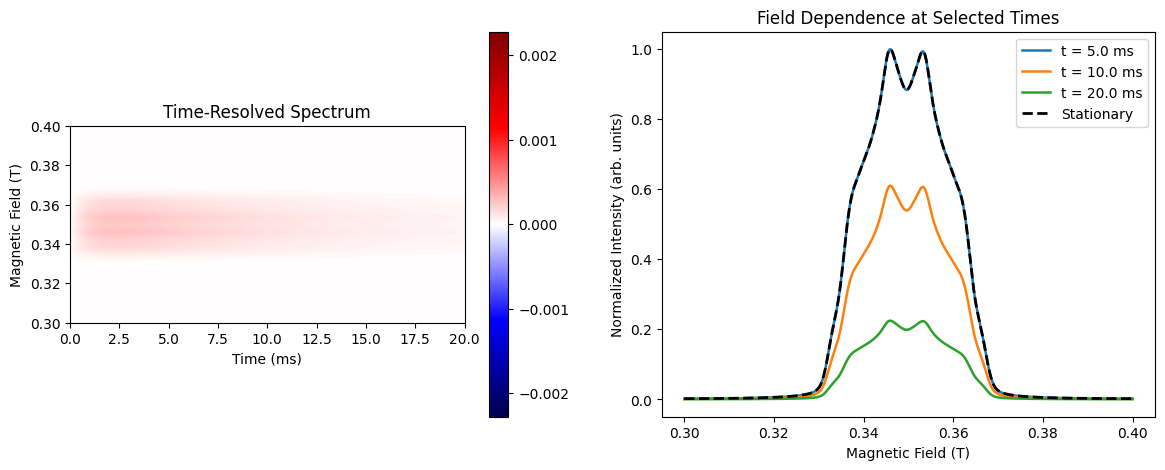

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plt.sca(ax1)
plot_heat_map(fields_np, time_np, spectrum_tr_2d_np)
plt.xlabel("Time (ms)")
plt.ylabel("Magnetic Field (T)")
plt.title("Time-Resolved Spectrum")

plt.sca(ax2)
plt.plot(fields_np, quart_time_spectrum, label=f"t = {t_quart*1e3:.1f} ms", lw=1.8)
plt.plot(fields_np, middle_time_spectrum, label=f"t = {t_mid*1e3:.1f} ms", lw=1.8)
plt.plot(fields_np, end_time_spectrum, label=f"t = {t_end*1e3:.1f} ms", lw=1.8)
plt.plot(fields_np, stationary_spectrum, '--', label="Stationary", lw=2.0, color='black')
plt.xlabel("Magnetic Field (T)")
plt.ylabel("Normalized Intensity (arb. units)")
plt.title("Field Dependence at Selected Times")
plt.legend()

plt.show()

Here we observe two effects:

1) Rapid relaxation to stationary spectra with 1 / free_probs time

2) Long-term decay of the triplet state

# 4. Density-Based Dynamics

MarS implements full density-matrix relaxation using the Lindblad master equation, which guarantees physical validity (positivity and trace preservation) of the evolving quantum state. The dynamics are governed by:

$$
\frac{d\rho}{dt} = -i[H, \rho] + \mathcal{R}[\rho],
$$

where $\rho$ is the density matrix, $H$ is the spin Hamiltonian, and $\mathcal{R}$ is the relaxation superoperator expressed as a sum over Lindblad ("jump") operators $L_k$:

$$
\mathcal{R}[\rho] = \sum_k \left( L_k \rho L_k^\dagger - \frac{1}{2} \{ L_k^\dagger L_k, \rho \} \right).
$$

MarS maps user-defined relaxation parameters directly onto specific jump operators:

---

### 1. **Out probabilities (`out_probs`)**  
To model irreversible loss.
- The next jump operator is used: $L_i = \sqrt{o_i}\, |i\rangle\langle i|$, where $\sqrt{o_i}$ is probability of loss from the level

---

### 2. **Free probabilities (`free_probs`)**  
Describe *spontaneous* transitions $|j\rangle \to |i\rangle$ that obey detailed balance at temperature $T$:  
- The next jump operator is used: $L_{ij} = \sqrt{w_{ij}}\, |i\rangle\langle j|$, where $\sqrt{w_{ij}}$ is probability of the transitions between levels

---

### 3. **Driven probabilities (`driven_probs`)**  
Represent *stimulated* transitions (e.g., microwave-induced flips).  
- The next jump operator is used: $L_{ij} = \sqrt{d_{ij}}\, |i\rangle\langle j|$ , where $\sqrt{d_{ij}}$  is probability of the transitions between levels

---

### 4. **Decoherence (`decoherence`)**  
Pure dephasing between levels $|i\rangle$ and $|j\rangle$ ($i \neq j$):  
- The next jump operator is used: $L_i = \sqrt{\gamma_i}\, |i\rangle\langle i|$, where $\gamma_i$ is probability of dephasing

---

### 5. **User-Defined superoperato (`relaxation_superop`)**  
Also it is possible to set the user-defined superoperator at the given basis




All jump operators are first defined in the user-specified basis (e.g., `"zfs"`), then transformed into the eigenbasis of the full Hamiltonian before assembly into $\mathcal{R}$.
Internally, MarS separates the total relaxation superoperator into two parts:

- $\hat{\mathcal{R}}_{\text{free}}$: includes `out_probs`, `free_probs`, and `decoherence`. This part enforces detailed balance.
- $\hat{\mathcal{R}}_{\text{driv}}$: contains only `driven_probs`. This part remained unmodified


#### 4.1 Rotating Wave Approximation

#### 4.2 Solution with Propagator computations

# 5. Context Algebra

MarS allows the construction of complex `Context` objects to describe realistic relaxation scenarios by combining simpler mechanisms. Two fundamental algebraic operations are supported:

- **Addition** (`context_1 + context_2`): combines independent relaxation pathways acting on the *same* spin system.
- **Multiplication** (`context_1 @ context_2`): constructs a composite system from *independent subsystems*, each with its own relaxation.

Both operations automatically handle basis transformations, detailed balance enforcement, and proper composition of kinetic matrices or relaxation superoperators.

---

#### 5.1. "Sum" of Relaxation Mechanisms

The addition of contexts corresponds to the physical situation where multiple relaxation processes (e.g., spin–lattice relaxation and phosphorescence) act simultaneously on the same set of states. In this case, the total relaxation operator is the sum of individual contributions **after transformation into the common eigenbasis of the full Hamiltonian**.

For population dynamics (kinetic approach), the final kinetic matrix is:
$$
K_{\text{total}} = K^{(1)} + K^{(2)} + \cdots
$$

For density-matrix dynamics, the total relaxation superoperator becomes:
$$
\hat{\mathcal{R}}_{\text{total}} = \hat{\mathcal{R}}^{(1)} + \hat{\mathcal{R}}^{(2)} + \cdots
$$

Let's return to the example of the triplet state. MarS context can be operates with several mechanisms at the same time

<img src="sum_context.png" alt="Drawing" style="width: 800px;"/>


In this system there are two relaxation mechanisms

1) Depopulation given in ZFS basis (or the same in the X,Y,Z) basis

2) Relaxation between levels given in eigen basis of spin hamiltonina

In [ ]:
out_probs = [0.1,]

context_depopulation = population.Context(sample=sample, basis="zfs", init_populations=initial_populations, out_probs=out_probs)


#### 5.2. "Multiplication" of Relaxation Mechanisms

The tensor product (`@`) of contexts describes a **composite quantum system** consisting of two (or more) weakly coupled or independent subsystems. The total Hilbert space is the tensor product of subsystem spaces, and initial states as well as relaxation operators combine accordingly.

For populations (kinetic picture):
$$
\mathbf{n}_{\text{total}} = \mathbf{n}^{(1)} \otimes \mathbf{n}^{(2)}, \quad
K_{\text{total}} = K^{(1)} \otimes I^{(2)} + I^{(1)} \otimes K^{(2)}
$$

For density matrices and superoperators:
$$
\rho_{\text{total}} = \rho^{(1)} \otimes \rho^{(2)}, \quad
\hat{\mathcal{R}}_{\text{total}} = \hat{\mathcal{R}}^{(1)} \otimes \hat{I}^{(2)} + \hat{I}^{(1)} \otimes \hat{\mathcal{R}}^{(2)}
$$
where $\hat{I}^{(k)}$ denotes the identity superoperator acting on subsystem $k$.

Let's consider an example of two triplets